In [1]:
import io, os, sys, types

In [2]:
import nbformat
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell


In [3]:
def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path
    
    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path

In [4]:
class NotebookLoader(object):
    """Module Loader for IPython Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path
    
    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)
        
        print ("importing notebook from %s" % path)
                                       
        # load the notebook object
        nb = nbformat.read(path, as_version=4)
        
        
        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod
        
        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__
        
        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

In [5]:
class NotebookFinder(object):
    """Module finder that locates IPython Notebooks"""
    def __init__(self):
        self.loaders = {}
    
    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return
        
        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)
        
        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

In [6]:
sys.meta_path.append(NotebookFinder())

importing notebook from pre_processing.ipynb


/Users/piyushghai/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


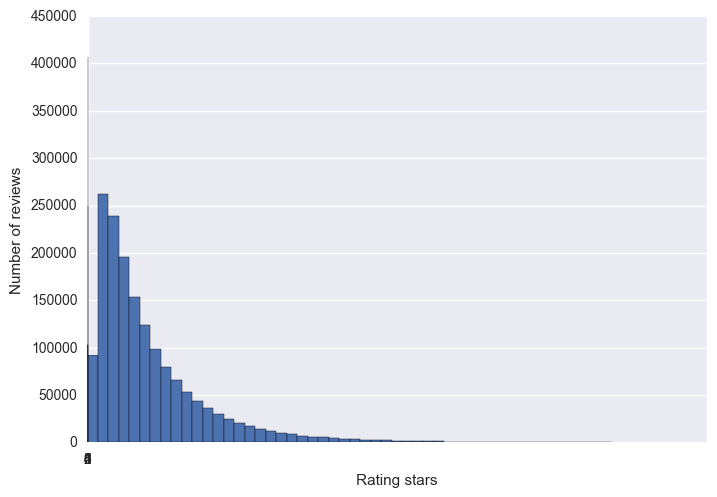

In [7]:
import pre_processing

In [23]:
# Clean all the reviews by removing stop words as well as punctutation marks
def process_reviews(data_set):
    clean_data_set = []
    for text in data_set:
        # Remove punctuations
        text = re.sub(r'[^a-zA-Z]', ' ', text)
        # To lowercase
        text = text.lower()
        # Remove stop words
        texts = [word for word in text.split() if word not in stop_words_set]
        try:
            clean_data_set.append(' '.join(texts))
        except:
            pass
    return clean_data_set

In [9]:
# Function to create the LDA model from the training dataset.
def perform_lda(train, totalTopics):
    corpus = []
    for text in train:
        # Remove punctuations
        text = re.sub(r'[^a-zA-Z]', ' ', text)
        # To lowercase
        text = text.lower()
        # Remove stop words
        texts = [word for word in text.lower().split() if word not in stop_words_set]
        try:
            corpus.append(texts)
        except:
            pass

    # Build dictionary
    dictionary = corpora.Dictionary(corpus)
    dictionary.save('restaurant_reviews.dict')
        
    # Build vectorized corpus
    corpus_vector = [dictionary.doc2bow(text) for text in corpus]
    
    lda = models.LdaModel(corpus_vector, num_topics=totalTopics, id2word=dictionary)
    return lda

# Generates a matrix of topic probabilities for each document in matrix
# Returns topic_dist for the input corpus, and all_dist, a running sum of all the corpuses
def getTopicDistMatrix(lda, totalTopics, corpus, all_dist, star):
    topic_dist = [0] * totalTopics
    # Load the dictionary
    dictionary = corpora.Dictionary.load("restaurant_reviews.dict")
    # For every reviewDoc in the corpus, compute the prob dist matrix for each term
    for review in corpus:
        vec = dictionary.doc2bow(review.lower().split())
        output = lda[vec]
        highest_prob = 0
        highest_topic = 0
        temp = [0] * totalTopics    # List to keep track of topic distribution for each document
        for topic in output:
            this_topic, this_prob = topic
            temp[this_topic] = this_prob
            if this_prob > highest_prob:
                highest_prob = this_prob 
                highest_topic = this_topic
        temp.append(star)
        all_dist.append(temp)
        topic_dist[highest_topic] += 1
    return topic_dist, all_dist



In [11]:
import time
import datetime

import cPickle as pickle
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pylab
import re
import scipy as sp
import seaborn

from gensim import corpora, models
from nltk.corpus import stopwords
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.lda import LDA
from sklearn.qda import QDA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

#Set of English language Stop Words from the dictionary
stop_words_set = set(stopwords.words("english"))

totalTopics = 15

/Users/piyushghai/anaconda/lib/python2.7/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")
/Users/piyushghai/anaconda/lib/python2.7/site-packages/sklearn/lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
/Users/piyushghai/anaconda/lib/python2.7/site-packages/sklearn/qda.py:4: DeprecationWarning: qda.QDA has been moved to discriminant_analysis.QuadraticDiscriminantAnalysis in 0.17 and will be removed in 0.19.
  "in 0.17 and will be removed in 0.19.", DeprecationWarning)


In [13]:
from pre_processing import review_data as resto_review
# Group all reviews per star rating and extract text out of them
starsGroup = resto_review.groupby('stars_review')

text_star_1 = starsGroup.get_group(1.0)['text']
text_star_2 = starsGroup.get_group(2.0)['text']
text_star_3 = starsGroup.get_group(3.0)['text']
text_star_4 = starsGroup.get_group(4.0)['text']
text_star_5 = starsGroup.get_group(5.0)['text']

In [15]:
# Optional : To reduce the dataset size and prevent laptop from frying, reduce the dataset size by sampling
sampling = 30000 # No of rows to be sampled

text_star_1 = text_star_1.sample(sampling)
text_star_2 = text_star_2.sample(sampling)
text_star_3 = text_star_3.sample(sampling)
text_star_4 = text_star_4.sample(sampling)
text_star_5 = text_star_5.sample(sampling)


In [16]:
label_star_1 = [1.0]*len(text_star_1)
label_star_2 = [2.0]*len(text_star_2)
label_star_3 = [3.0]*len(text_star_3)
label_star_4 = [4.0]*len(text_star_4)
label_star_5 = [5.0]*len(text_star_5)

In [18]:
from sklearn.cross_validation import train_test_split

# Create test and training dataset. We use 80-20 sampling here. We can use 66-33 sampling too
train_stars_1, test_stars_1, train_labels_stars_1, all_1stars_labels_test = train_test_split(text_star_1, label_star_1, test_size=0.30)
train_stars_2, test_stars_2, train_labels_stars_2, all_2stars_labels_test = train_test_split(text_star_2, label_star_2, test_size=0.30)
train_stars_3, test_stars_3, train_labels_stars_3, all_3stars_labels_test = train_test_split(text_star_3, label_star_3, test_size=0.30)
train_stars_4, test_stars_4, train_labels_stars_4, all_4stars_labels_test = train_test_split(text_star_4, label_star_4, test_size=0.30)
train_stars_5, test_stars_5, train_labels_stars_5, all_5stars_labels_test = train_test_split(text_star_5, label_star_5, test_size=0.30)

In [19]:
print(len(train_labels_stars_1))

21000


In [24]:
## Cleaning all the reviews and building corpus out of them
corpus_5stars = process_reviews(train_stars_5)
corpus_4stars = process_reviews(train_stars_4)
corpus_3stars = process_reviews(train_stars_3)
corpus_2stars = process_reviews(train_stars_2)
corpus_1stars = process_reviews(train_stars_1)

In [25]:
print "Number of 5-star reviews after processing: ", len(corpus_5stars)
print "Number of 4-star reviews after processing: ", len(corpus_4stars)
print "Number of 3-star reviews after processing: ", len(corpus_3stars)
print "Number of 2-star reviews after processing: ", len(corpus_2stars)
print "Number of 1-star reviews after processing: ", len(corpus_1stars)


Number of 5-star reviews after processing:  21000
Number of 4-star reviews after processing:  21000
Number of 3-star reviews after processing:  21000
Number of 2-star reviews after processing:  21000
Number of 1-star reviews after processing:  21000


In [26]:
# Creating combined dataset for training, containing representation of all the 5 star ratings possible
all_5_4_train = np.append(corpus_5stars, corpus_4stars)
all_5_4_3_train = np.append(all_5_4_train, corpus_3stars)
all_5_4_3_2_train = np.append(all_5_4_3_train, corpus_2stars)
all_text_train = np.append(all_5_4_3_2_train, corpus_1stars)

In [27]:
# Building the LDA model
%time lda = perform_lda(all_text_train, totalTopics)

CPU times: user 4min 58s, sys: 4.34 s, total: 5min 3s
Wall time: 5min 7s


In [28]:
topic_dist_list = []

# Keep a separate list to count topics
topic_dist_5stars = []
topic_dist_4stars = []
topic_dist_3stars = []
topic_dist_2stars = []
topic_dist_1stars = []

In [29]:
topic_dist_5stars, topic_dist_list = getTopicDistMatrix(lda, totalTopics, corpus_5stars, topic_dist_list, 5)
topic_dist_4stars, topic_dist_list = getTopicDistMatrix(lda, totalTopics, corpus_4stars, topic_dist_list, 4)
topic_dist_3stars, topic_dist_list = getTopicDistMatrix(lda, totalTopics, corpus_3stars, topic_dist_list, 3)
topic_dist_2stars, topic_dist_list = getTopicDistMatrix(lda, totalTopics, corpus_2stars, topic_dist_list, 2)
topic_dist_1stars, topic_dist_list = getTopicDistMatrix(lda, totalTopics, corpus_1stars, topic_dist_list, 1)

In [30]:
cols = []
for i in xrange(1, totalTopics+1):
    cols.append("Topic"+ str(i))
cols.append("Star")

In [31]:
topic_dist_train_all_stars = pd.DataFrame(topic_dist_list, columns=cols)

In [32]:
corpus_5stars_test = process_reviews(test_stars_5)
corpus_4stars_test = process_reviews(test_stars_4)
corpus_3stars_test = process_reviews(test_stars_3)
corpus_2stars_test = process_reviews(test_stars_2)
corpus_1stars_test = process_reviews(test_stars_1)

print "Number of 5-star reviews after processing: ", len(corpus_5stars_test)
print "Number of 4-star reviews after processing: ", len(corpus_4stars_test)
print "Number of 3-star reviews after processing: ", len(corpus_3stars_test)
print "Number of 2-star reviews after processing: ", len(corpus_2stars_test)
print "Number of 1-star reviews after processing: ", len(corpus_1stars_test)


Number of 5-star reviews after processing:  9000
Number of 4-star reviews after processing:  9000
Number of 3-star reviews after processing:  9000
Number of 2-star reviews after processing:  9000
Number of 1-star reviews after processing:  9000


In [33]:
all_5_4_test = np.append(corpus_5stars_test, corpus_4stars_test)
all_5_4_3_test = np.append(all_5_4_test, corpus_3stars_test)
all_5_4_3_2_test = np.append(all_5_4_3_test, corpus_2stars_test)
all_text_test = np.append(all_5_4_3_2_test, corpus_1stars_test)


In [34]:
topic_dist_list = []

# Keep a separate list to count topics
topic_dist_5stars = []
topic_dist_4stars = []
topic_dist_3stars = []
topic_dist_2stars = []
topic_dist_1stars = []


topic_dist_5stars, topic_dist_list = getTopicDistMatrix(lda, totalTopics, corpus_5stars_test, topic_dist_list, 5)
topic_dist_4stars, topic_dist_list = getTopicDistMatrix(lda, totalTopics, corpus_4stars_test, topic_dist_list, 4)
topic_dist_3stars, topic_dist_list = getTopicDistMatrix(lda, totalTopics, corpus_3stars_test, topic_dist_list, 3)
topic_dist_2stars, topic_dist_list = getTopicDistMatrix(lda, totalTopics, corpus_2stars_test, topic_dist_list, 2)
topic_dist_1stars, topic_dist_list = getTopicDistMatrix(lda, totalTopics, corpus_1stars_test, topic_dist_list, 1)


In [35]:
cols = []
for i in xrange(1, totalTopics+1):
    cols.append("Topic"+ str(i))
cols.append("Star")


In [36]:
topic_dist_test_all_stars = pd.DataFrame(topic_dist_list, columns=cols)

features = list(topic_dist_train_all_stars.columns[:totalTopics])

In [37]:
x_train = topic_dist_train_all_stars[features]
y_train = topic_dist_train_all_stars['Star']

x_test = topic_dist_test_all_stars[features]
y_test = topic_dist_test_all_stars['Star'] 

In [38]:
clfs = [KNeighborsClassifier(), MultinomialNB(), LogisticRegression(), RandomForestClassifier(n_estimators=100, n_jobs=2), AdaBoostClassifier(n_estimators=100)]
clf_names = ['Nearest Neighbors', 'Multinomial Naive Bayes', 'Logistic Regression', 'Random Forest', 'AdaBoost']

LDAResults = {}
for (i, clf_) in enumerate(clfs):
    clf = clf_.fit(x_train, y_train)
    preds = clf.predict(x_test)
    
    precision = metrics.precision_score(y_test, preds)
    recall = metrics.recall_score(y_test, preds)
    f1 = metrics.f1_score(y_test, preds)
    accuracy = accuracy_score(y_test, preds)
    report = classification_report(y_test, preds)
    matrix = metrics.confusion_matrix(y_test, preds, labels=starsGroup.groups.keys())
    
    data = {'precision':precision,
            'recall':recall,
            'f1_score':f1,
            'accuracy':accuracy,
            'clf_report':report,
            'clf_matrix':matrix,
            'y_predicted':preds}
    
    LDAResults[clf_names[i]] = data

cols = ['precision', 'recall', 'f1_score', 'accuracy']
LDA_Prediction_Perf = pd.DataFrame(LDAResults).T[cols].T
LDA_Prediction_Perf


/Users/piyushghai/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/piyushghai/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of sco

,AdaBoost,Logistic Regression,Multinomial Naive Bayes,Nearest Neighbors,Random Forest
precision,0.328119,0.320558,0.321637,0.281038,0.313159
recall,0.342089,0.341178,0.338511,0.286244,0.320022
f1_score,0.330258,0.322069,0.324179,0.279558,0.315531
accuracy,0.342089,0.341178,0.338511,0.286244,0.320022


In [39]:
for model, val in LDAResults.iteritems():
    print '-------'+'-'*len(model)
    print 'MODEL:', model
    print '-------'+'-'*len(model)
    print 'The precision for this classifier is ' + str(val['precision'])
    print 'The recall for this classifier is    ' + str(val['recall'])
    print 'The f1 for this classifier is        ' + str(val['f1_score'])
    print 'The accuracy for this classifier is  ' + str(val['accuracy'])
    print 'The confusion matrix for this classifier is  \n' + str(val['clf_matrix'])
    print '\nHere is the classification report:'
    print val['clf_report']

--------------------
MODEL: Random Forest
--------------------
The precision for this classifier is 0.313159423717
The recall for this classifier is    0.320022222222
The f1 for this classifier is        0.315531178935
The accuracy for this classifier is  0.320022222222
The confusion matrix for this classifier is  
[[4771 1788  993  693  755]
 [2748 2160 1636 1306 1150]
 [1493 1794 2096 1983 1634]
 [ 936 1327 2059 2481 2197]
 [ 919 1144 1561 2483 2893]]

Here is the classification report:
             precision    recall  f1-score   support

          1       0.44      0.53      0.48      9000
          2       0.26      0.24      0.25      9000
          3       0.25      0.23      0.24      9000
          4       0.28      0.28      0.28      9000
          5       0.34      0.32      0.33      9000

avg / total       0.31      0.32      0.32     45000

---------------
MODEL: AdaBoost
---------------
The precision for this classifier is 0.328118902246
The recall for this classifier i